In [1]:
#import HogProf.utils.goautils as goa
#import HogProf.profiler as profiler
import sys
sys.path.append('..')
sys.path.append('../utils')
sys.path.append('../..')

%load_ext autoreload
%autoreload 2

import profiler
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
import pickle
#import community as community_louvain
#from networkx.algorithms import community

## Set up and load profile database

In [2]:
#lets load a compiled db containing the OMA root HOGs into a profiler oject 
folder = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/birds/'
p =profiler.Profiler(lshforestpath = folder + 'newbirdsnewlshforest.pkl' , hashes_h5=folder+'newbirdshashes.h5' , mat_path= None, 
                          oma ='/work/FAC/FBM/DBC/cdessim2/default/aaltenho/birds/OmaStandalone_378_v3/OmaServer.h5' , nsamples = 256 ,
                     mastertree = '/work/FAC/FBM/DBC/cdessim2/default/smajidi1/bird_project/speciestree_scinames3.nwk')


loading lsh
indexing lsh
h5 <HDF5 file "newbirdshashes.h5" (mode r)> <KeysViewHDF5 ['NoFilterNoMask']>
704
DONE


In [3]:
#Documentation for the proiler class
help(p)

Help on Profiler in module profiler object:

class Profiler(builtins.object)
 |  Profiler(lshforestpath=None, hashes_h5=None, mat_path=None, oma=False, nsamples=256, mastertree=None)
 |  
 |  A profiler object allows the user to query the LSH with HOGs and get a list of result HOGs back
 |  
 |  Methods defined here:
 |  
 |  __init__(self, lshforestpath=None, hashes_h5=None, mat_path=None, oma=False, nsamples=256, mastertree=None)
 |      The Profiler class initializes a profiler object for querying the LSH with HOGs and returning a list of result HOGs.
 |      
 |      Attributes:
 |      lshobj (object): LSH object for querying.
 |      hashes_h5 (h5py.File): H5 file containing HOGs.
 |      nsamples (int): Number of samples to use.
 |      tree (ete3.Tree): Master tree used for generating taxa index.
 |      tree_string (str): String representation of the master tree.
 |      taxaIndex (dict): Dictionary mapping taxa names to their indices in the master tree.
 |      ReverseTaxaInd

In [4]:
hog_id_aves = [x[0] for x in p.db_obj.get_all_hogs_at_level('Aves')]

Cannot load Hogs_per_Level. extracting from main table. SLOW!


In [5]:
def grabHog(ID, verbose = True):
    try:
        entry = p.db_obj.entry_by_entry_nr(p.db_obj.id_resolver.resolve(ID))
        print(entry)
        return entry
    except:
        return np.nan,np.nan

In [6]:
qid = ['AGAROS_R02287', 'AGAROS_R02288', 'AGAROS_R05425', 'AGAROS_R04072', 'AGAROS_R04073']

In [7]:
#grabHog('AGAROS_R02287')
hog_ids = [grabHog(q) for q in qid]
print(hog_ids)


(61382, 26874312, 2212, 37404, b'HOG:0045401', b'scaffold1182', 16174, 72387, 1, 0, b'AGAROS_R02287', 80500174, 6634, b'e929622096cf011104bfea9ad9bc3a91', 0, 0, b'', -1, -1)
(61383, 26876524, 372, 68357, b'HOG:0020142', b'scaffold1182', 100640, 105785, 1, 0, b'AGAROS_R02288', 80506808, 1114, b'216b44119b3c9bc1eab322f1db46246f', 0, 0, b'', -1, -1)
(64410, 28273138, 856, 70349, b'HOG:0034115.5c', b'scaffold1425', 9673, 46632, -1, 0, b'AGAROS_R05425', 84690596, 2566, b'b0f0351f63a3545bc202cd1ee610f0b7', 0, 0, b'', -1, -1)
(74591, 32584990, 889, 5032, b'HOG:0040272', b'scaffold1365', 82095, 88758, 1, 0, b'AGAROS_AGAROS_R04073', 97605790, 2665, b'56a9ae2b86089e2a82a2934dd0066555', 0, 0, b'', -1, -1)
(74591, 32584990, 889, 5032, b'HOG:0040272', b'scaffold1365', 82095, 88758, 1, 0, b'AGAROS_AGAROS_R04073', 97605790, 2665, b'56a9ae2b86089e2a82a2934dd0066555', 0, 0, b'', -1, -1)
[(61382, 26874312, 2212, 37404, b'HOG:0045401', b'scaffold1182', 16174, 72387, 1, 0, b'AGAROS_R02287', 80500174, 6634

In [8]:
hits = p.hog_query( hog_id= 'AGAROS_R02287' , k = 20 )
print(hits)

hashes = p.pull_hashes([10]+ [int(x) for x in hits])
all_sig  = list(hashes.values())
jkern = [ [ h1.jaccard(h2) for j,h2 in enumerate(all_sig) ] for i,h1 in enumerate(list(all_sig))]

['30795', '29601', '30650', '29322', '37655', '37084', '42983', '43253', '42547', '33515', '33049', '29590', '42497', '38503', '31456', '29044', '32602', '36193', '31759', '32388']


## Create a profiler graph

In [9]:
p.db_obj.get_all_hogs_at_level('Aves')[0]

Cannot load Hogs_per_Level. extracting from main table. SLOW!


(45036, b'HOG:0045036', b'Aves', -1., -1, 42, False)

In [10]:
hog_id_aves = [ int(x[0]) for x in p.db_obj.get_all_hogs_at_level('Aves') ]

Cannot load Hogs_per_Level. extracting from main table. SLOW!


In [11]:
rowmap_aves = { h:i for i,h in enumerate(hog_id_aves) }

In [12]:
hog_id_aves[10]
rowmap_aves[hog_id_aves[10]]

10

In [13]:
#Create a weighted graph of the HOGs in a list (hogids) using the Jaccard distance to weight edges and using only the k first profiles to build it (default:100)
from scipy.sparse import lil_matrix
import tqdm 

def get_weighted_graph(profiler, rowmap , hog_ids, k=100):
    #Not sure if should be len of hog_ids or of the total profiler - TODO check
    dist_mat = lil_matrix((len(hog_ids),len(hog_ids)))
    qhogs = []
    pool =[]
    results = []
    count = 0
    nsamples = len(hog_ids)
    with tqdm.tqdm(total=nsamples) as pbar:
        for i,qHOG in enumerate(hog_ids):
            pbar.set_description('processed: %d' % (1 + i))
            pbar.update(1)  
            count +=1
            res= profiler.hog_query( fam_id=qHOG , k = k )
            hashes = profiler.pull_hashes( [qHOG] +[int(x) for x in res] )
            query = hashes[qHOG]
            for tHOG in res:
                if int(tHOG) in rowmap:
                    target = hashes[int(tHOG)]
                    jacc = query.jaccard(target)
                    dist_mat[i, rowmap[int(tHOG)] ]= jacc
    dist_mat += dist_mat.T
    dist_mat/=2
    
    return dist_mat.tocoo()
    

In [14]:
aves_mat = get_weighted_graph(p, rowmap_aves, hog_id_aves, k=100)

processed: 20167: 100%|██████████| 20167/20167 [47:22<00:00,  7.09it/s]  


(array([  27974.,  221338.,  291736.,  489846., 1681390.,   29860.,
          27974.,   37230.,   62256.,  191509.]),
 array([0.0078125 , 0.10703125, 0.20625   , 0.30546875, 0.4046875 ,
        0.50390625, 0.603125  , 0.70234375, 0.8015625 , 0.90078125,
        1.        ]),
 <BarContainer object of 10 artists>)

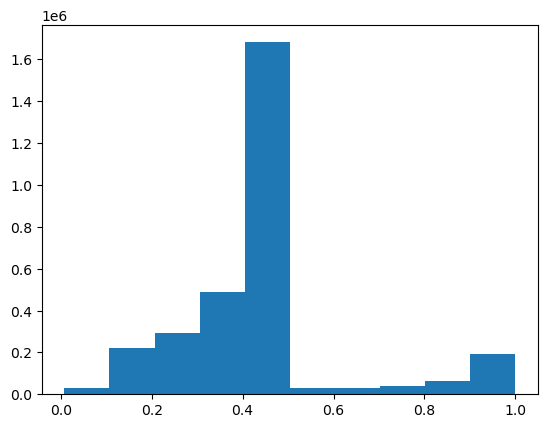

In [15]:
plt.hist(aves_mat.data)

In [16]:
import pickle
with open('aves_mat.pkl' , 'wb') as matout:
    matout.write(pickle.dumps(aves_mat))

In [ ]:
avlil = aves_mat.tolil()
thresh = .7

idx = np.where( np.array(aves_mat.data) > thresh )[0]
row = aves_mat.row[idx]
col = aves_mat.col[idx]
data = aves_mat.data[idx]
submat = scipy.sparse.coo_array((data, (row, col)), shape = aves_mat.shape )
print(submat)

In [ ]:
plt.spy(submat, markersize=.01)

In [49]:
import networkx as nx
final=nx.from_scipy_sparse_array(submat, parallel_edges=False, create_using=None, edge_attribute='weight')

In [ ]:
with open('/work/FAC/FBM/DBC/cdessim2/default/Bird_project/Profiler/Graphs/Aves_k100.pkl', 'rb') as handle:
    final = pickle.load(handle)

## Clustering

In [50]:
#Clustering
clusters = nx.community.louvain_communities(final, weight='weight')

In [41]:
with open("/work/FAC/FBM/DBC/cdessim2/default/Bird_project/Profiler/Graphs/clusters_louvain.tsv",'w') as graph_file:
    for k,v in clusters.items():
        graph_file.write(str(k)+'\t'+str(v)+'\n')

PermissionError: [Errno 13] Permission denied: '/work/FAC/FBM/DBC/cdessim2/default/Bird_project/Profiler/Graphs/clusters_louvain.tsv'

In [ ]:
#Visualize the graph
plt.figure( figsize = (17,17))
pos = nx.spring_layout( final , weight='weight')
weights = np.asarray([e[2]['weight'] for e in final.edges(data = True)])
colors = [clusters.get(x) for x in final.nodes()]

nx.draw(final, pos=pos, edge_color='grey',node_color=colors, width=10*weights, node_size= 500,alpha = .5 ) 


In [42]:
#with open("/work/FAC/FBM/DBC/cdessim2/default/Bird_project/Profiler/Graphs/cytoscape_graph.json", 'w') as json_cyto:
#    print(str(nx.cytoscape_data(final))[0:40])
nx.write_graphml(final,"/work/FAC/FBM/DBC/cdessim2/default/Bird_project/Profiler/Graphs/cytoscape_graph.graphml")

## Graph with Jaccard threshold:0.9

In [7]:
#lets compare the organisation of the complex in both as graph structures
import networkx as nx
final_09 = build_graph_object(aves_mat, 0.9)

pos09 = nx.spring_layout( final_09 , weight='weight')
weights09 = np.asarray([e[2]['weight'] for e in jG.edges(data = True)])

Graph with 35874 nodes and 1563196 edges


In [ ]:
clusters_09 = community_louvain.best_partition(final_09, weight='weight')

In [11]:
colors_09 = [clusters_09.get(x) for x in final_09.nodes()]


In [44]:
    
with open('/work/FAC/FBM/DBC/cdessim2/default/Bird_project/Profiler/Graphs/Aves_k100_09.pkl', 'rb') as handle:
    final_09 = pickle.load(handle)

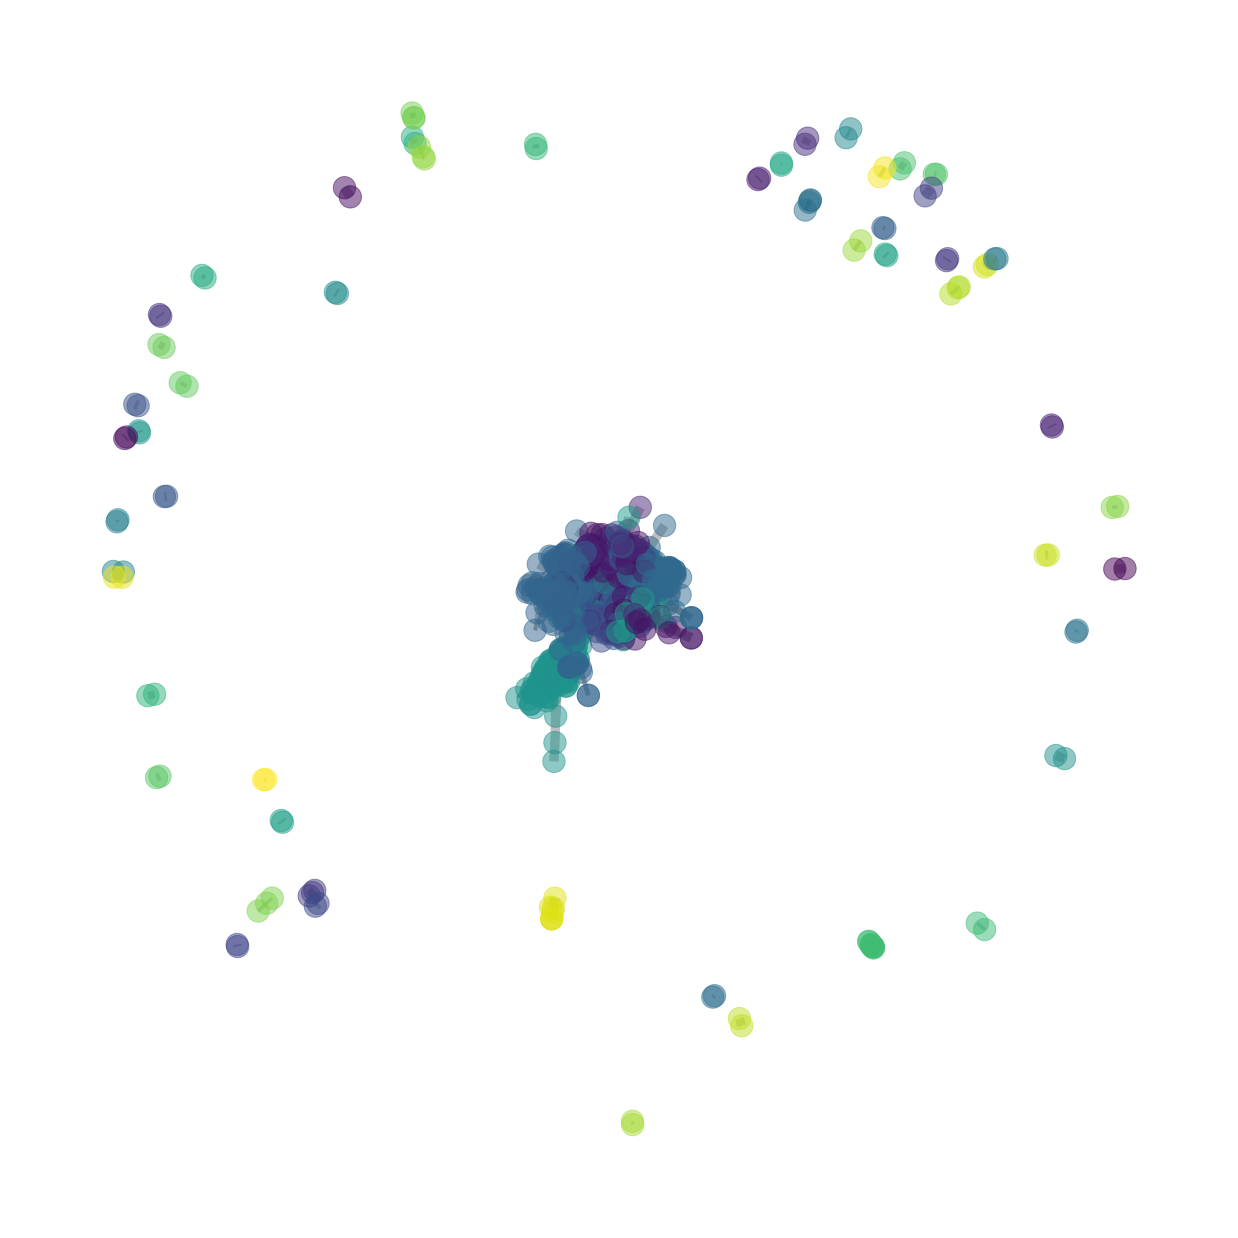

In [12]:
plt.figure( figsize = (17,17))
nx.draw(final_09, pos=pos09, edge_color='grey',node_color=colors_09, width=10*weights09, node_size= 500,alpha = .5 ) 


In [43]:
nx.write_graphml(final_09,"/work/FAC/FBM/DBC/cdessim2/default/Bird_project/Profiler/Graphs/cytoscape_graph_09.graphml")
with open("/work/FAC/FBM/DBC/cdessim2/default/Bird_project/Profiler/Graphs/clusters_louvain_09.tsv",'w') as graph_file:
    for k,v in clusters_09.items():
        graph_file.write(str(k)+'\t'+str(v)+'\n')

## Miscellaneous tests

In [ ]:
import multiprocessing as mp
def distmp(args):
    if args == 0:
        return 0
    return  args[0].jaccard(args[1])
def jkern_mp(profiles,ncore = None):
    if ncore is None:
        pool = mp.Pool()
    else:
        pool = mp.Pool( ncore)
    jkern = [ pool.map( distmp, [ (h1,h2) if i<j else 0 for j,h2 in enumerate(list(profiles.hashsig)) ] , chunksize = 100 ) for i,h1 in enumerate(list(profiles.hashsig))]
    return jkern

In [94]:
hashes = p.pull_hashes( [x for x in hog_id_aves[0:5]] +[int(x) for x in results] )
all_sig  = list(hashes.values())

In [95]:
jkern = [ [ h1.jaccard(h2) if i<j else 0 for j,h2 in enumerate(all_sig) ] for i,h1 in enumerate(list(all_sig))]


In [ ]:
hashes

In [ ]:
#Provide an analysis of the Jaccard distribution using different k

In [3]:
def estimate_K(hog_list, draw=500, thr=0.75):
    subset  = random.sample(hog_list, draw)
    k_distrib = list()
    for qHOG in subset:
        res= p.hog_query( hog_id=qHOG , k = 35000 )

        hashes = p.pull_hashes( [qHOG] +[int(x) for x in res] )
        alljacc = list()
        query = hashes[qHOG]

        for tHOG in res:
            target = hashes[int(tHOG)]
            jacc = query.jaccard(target)
            alljacc.append(jacc)
        cumsum_jacc = np.cumsum(sorted(alljacc, reverse=True))
        total = cumsum_jacc[-1]
        prop_jacc = [jac/total for jac in cumsum_jacc]
        print(len(prop_jacc))
        
        for i,k in enumerate(prop_jacc):
            if k>0.75:
                print(i)
                k_distrib.append(i)
                break
    return k_distrib
estimate_K(hog_id_aves)

NameError: name 'hog_id_aves' is not defined